In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg

/tmp/ipykernel_2671301/2501157616.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
window = 5
file_path = './in/copper_log_returns_{}d_final.csv'.format(window)
targ = 'LMCADY_acu_{}d_log'.format(window)

df = pd.read_csv(file_path, parse_dates=True)

df = df.sort_values(by='Date')

time_series = df[targ]

time_series

0       0.040542
1       0.015400
2       0.011601
3       0.027062
4       0.023340
          ...   
5545    0.023212
5546    0.007737
5547    0.026616
5548    0.046886
5549    0.048523
Name: LMCADY_acu_5d_log, Length: 5550, dtype: float64

In [3]:
LMCADY_train, LMCADY_test = train_test_split(time_series, test_size=0.02, shuffle=False)
LMCADY_train

0       0.040542
1       0.015400
2       0.011601
3       0.027062
4       0.023340
          ...   
5434   -0.017571
5435   -0.009421
5436    0.005294
5437    0.014017
5438    0.006657
Name: LMCADY_acu_5d_log, Length: 5439, dtype: float64

In [4]:
print(LMCADY_test.head())
LMCADY_test.tail()

5439    0.026487
5440    0.031547
5441    0.025339
5442    0.009831
5443    0.022462
Name: LMCADY_acu_5d_log, dtype: float64


5545    0.023212
5546    0.007737
5547    0.026616
5548    0.046886
5549    0.048523
Name: LMCADY_acu_5d_log, dtype: float64

In [5]:
def evaluate_ar_model(train_series, test_series, lags=5):

    if not isinstance(train_series.index, pd.DatetimeIndex):
        train_series.index = pd.RangeIndex(start=0, stop=len(train_series))

    predictions = []

    current_train = train_series.copy()
    for actual in test_series:
        if len(current_train) <= lags:
            print(f"No hay suficientes observaciones para {lags} lags. Terminando el ciclo.")
            break

        model = AutoReg(current_train, lags=lags)
        model_fit = model.fit()

        prediction = model_fit.predict(start=len(current_train), end=len(current_train+window), dynamic=False)

        predictions.append(prediction.iloc[0])
        # print("pred {:.6f}, {:.6f}".format(prediction.iloc[0],actual))

        current_train = pd.concat([current_train, pd.Series([actual], index=[len(current_train)])])

    return pd.Series(predictions, index=test_series.index)

In [6]:
def calculate_rmse(predictions, actual):
    # las predicciones para n se comparan con los valores reales en n+5 
    # por lo que se deben desplazar 5 posiciones
    actual_shift = actual.shift(-window)
    # print(actual)
    # print(predictions)

    # recortar los valores nulos generados por el desplazamiento
    actual_shift_drop = actual_shift.dropna()
    # recortar las ultimas 5 predicciones
    predictions_shift = predictions[:-window]

    
    # print(actual)
    # print(predictions)


    # Asegurarse de que las series sean de igual longitud
    if len(predictions_shift) != len(actual_shift_drop):
        raise ValueError("Las predicciones y los valores reales deben tener la misma longitud.")

    # Calcular el RMSE
    mse = mean_squared_error(actual_shift_drop, predictions_shift)
    rmse = np.sqrt(mse)
    return rmse

In [7]:
stop_lag = 20

best_predictions = None
best_lags = None
best_rmse = 999.9

# LMCADY_test = LMCADY_test.shift(-5)
# LMCADY_test.dropna(inplace=True)

for lags in range(1,stop_lag+1,1):
    LMCADY_predictions = evaluate_ar_model(LMCADY_train, LMCADY_test, lags=lags)

    LMCADY_predictions = LMCADY_predictions[:-window]
    
    LMCADY_rmse = calculate_rmse(LMCADY_predictions, LMCADY_test.shift(-window).dropna())
    print(f"AR> RMSE {lags} lags: {LMCADY_rmse:.6f}")

    if LMCADY_rmse < best_rmse:
        best_rmse = LMCADY_rmse
        best_lags = lags
        best_predictions = LMCADY_predictions


AR> RMSE 1 lags: 0.030599
AR> RMSE 2 lags: 0.030652
AR> RMSE 3 lags: 0.030890
AR> RMSE 4 lags: 0.031031
AR> RMSE 5 lags: 0.031537
AR> RMSE 6 lags: 0.030722
AR> RMSE 7 lags: 0.030764
AR> RMSE 8 lags: 0.030926
AR> RMSE 9 lags: 0.031103
AR> RMSE 10 lags: 0.031214
AR> RMSE 11 lags: 0.031199
AR> RMSE 12 lags: 0.031202
AR> RMSE 13 lags: 0.031175
AR> RMSE 14 lags: 0.031135
AR> RMSE 15 lags: 0.030999
AR> RMSE 16 lags: 0.031536
AR> RMSE 17 lags: 0.031519
AR> RMSE 18 lags: 0.031491
AR> RMSE 19 lags: 0.031448
AR> RMSE 20 lags: 0.031469


In [8]:
std_prueba = LMCADY_test.describe()['std']
print("El mejor rendimiento: {} lags, rmse = {:.6f} vs. std = {:.6f}".format(best_lags,best_rmse,std_prueba))
# print("Predicciones:")
# print(best_predictions)

El mejor rendimiento: 1 lags, rmse = 0.030599 vs. std = 0.022036


In [9]:
def plot_predictions(test_series, predictions, title, best_lags, markersize=3):
    plt.figure(figsize=(14, 2.5))

    plt.plot(test_series.index, test_series, label="Actual", marker='o', linestyle='-', markersize=markersize)
    plt.plot(test_series.index, predictions, label="Predicted", marker='x', linestyle='--', markersize=markersize)
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)


    plt.title(f"AR Model: {title} - {best_lags} lags")
    plt.legend()
    plt.show()

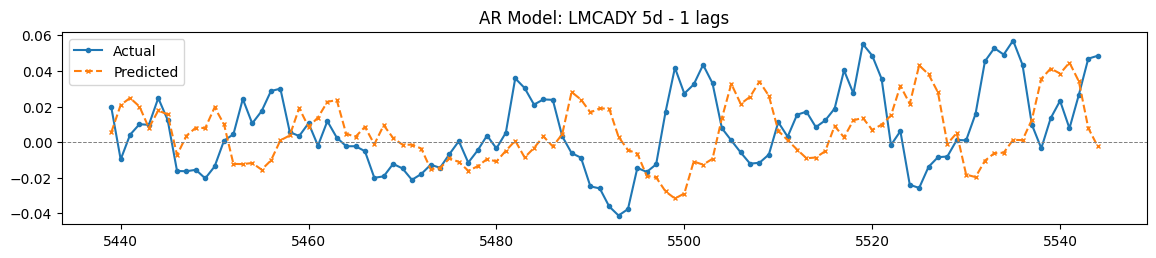

In [10]:
plot_predictions(LMCADY_test.shift(-window).dropna(), best_predictions, "LMCADY {}d".format(window), best_lags, markersize=3)